In [1]:
import yfinance as yf

# Download historical stock data for Microsoft (MSFT)
df = yf.download('MSFT', start='2008-01-01', end='2011-01-01')

[*********************100%***********************]  1 of 1 completed


In [2]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
register_matplotlib_converters()

In [3]:
device = torch.device("mps")

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,35.790001,35.959999,35.000000,35.220001,25.489267,63004200
2008-01-03,35.220001,35.650002,34.860001,35.369999,25.597824,49599600
2008-01-04,35.189999,35.200001,34.090000,34.380001,24.881342,72090800
2008-01-07,34.549999,34.799999,34.250000,34.610001,25.047792,80164300
2008-01-08,34.709999,34.709999,33.400002,33.450001,24.208282,79148300


In [5]:
y = df['Close'].values.astype(float)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 757 entries, 2008-01-02 to 2010-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       757 non-null    float64
 1   High       757 non-null    float64
 2   Low        757 non-null    float64
 3   Close      757 non-null    float64
 4   Adj Close  757 non-null    float64
 5   Volume     757 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.4 KB


In [7]:
df.dropna(inplace=True)

In [8]:
y.shape

(757,)

### window sizes - 30,90,126 and 252

In [9]:
#starting with 30
#testing points will always be 252 to check is seasonal pattern is captured or not
test_size = 30

In [10]:
train_size = len(y) - test_size

In [11]:
train_set = y[:train_size]
test_set = y[train_size:]

In [12]:
train_set

array([35.22000122, 35.36999893, 34.38000107, 34.61000061, 33.45000076,
       34.43999863, 34.33000183, 33.90999985, 34.38999939, 34.        ,
       33.22999954, 33.11000061, 33.00999832, 31.95999908, 31.93000031,
       33.25      , 32.93999863, 32.72000122, 32.59999847, 32.20000076,
       32.59999847, 30.45000076, 30.19000053, 29.06999969, 28.52000046,
       28.12000084, 28.55999947, 28.20999908, 28.34000015, 28.95999908,
       28.5       , 28.42000008, 28.17000008, 28.21999931, 28.10000038,
       27.68000031, 27.84000015, 28.37999916, 28.26000023, 27.93000031,
       27.20000076, 26.98999977, 27.59000015, 28.12000084, 27.56999969,
       27.87000084, 28.04999924, 29.28000069, 28.62999916, 28.62000084,
       27.95999908, 28.29999924, 29.42000008, 28.62000084, 29.18000031,
       29.17000008, 29.13999939, 28.55999947, 28.04999924, 27.90999985,
       28.37999916, 29.5       , 29.15999985, 29.        , 29.15999985,
       29.15999985, 28.75      , 28.88999939, 29.11000061, 28.28

In [13]:
test_set

array([25.84000015, 25.69000053, 25.72999954, 25.12000084, 25.37000084,
       25.25      , 25.30999947, 25.26000023, 26.04000092, 26.88999939,
       27.02000046, 26.84000015, 26.87000084, 27.22999954, 27.07999992,
       27.34000015, 27.25      , 27.62000084, 27.85000038, 27.98999977,
       27.89999962, 27.80999947, 28.06999969, 28.19000053, 28.29999924,
       28.06999969, 28.01000023, 27.96999931, 27.85000038, 27.90999985])

### Normalize data

In [14]:
from sklearn.preprocessing import MinMaxScaler
sclr = MinMaxScaler(feature_range=(-1,1))
train_norm = sclr.fit_transform(train_set.reshape(-1,1))

In [15]:
train_norm = torch.Tensor(train_norm).view(-1)

### create sequences

In [16]:
def input_data(seq,window_size):
    L = len(seq)
    out = []
    for i in range(L-window_size):
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        out.append((window,label))
    return out

In [17]:
window_size = 15
train_data = input_data(train_norm,window_size)

In [18]:
class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=32,out_size=1,num_layers=2,bidirectional=False):
        super(LSTM,self).__init__()
        #create attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_dir = 2 if bidirectional else 1
        self.hidden = (torch.zeros(self.num_layers * self.num_dir,1,hidden_size),
                      torch.zeros(self.num_layers * self.num_dir,1,hidden_size))
        #create lstm and linear 
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,bidirectional=bidirectional)
        self.linear= nn.Linear(self.num_dir*hidden_size,out_size)
    
    def forward(self,seq):
        lstm_out,self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [19]:
model = LSTM()

In [20]:
model

LSTM(
  (lstm): LSTM(1, 32, num_layers=2)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [21]:
num_epochs = 105
optimizer = torch.optim.Adam(model.parameters(),lr=0.005)
criterion = nn.MSELoss()

In [22]:
import time
start = time.time()
for epoch in range(num_epochs):
    for seq,label in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size),
                      torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size))
        y_pred = model.forward(seq)
        loss = torch.sqrt(criterion(y_pred,label))
        loss.backward()
        optimizer.step()
    print(f"epoch : {epoch+1}/{num_epochs} loss : {loss.item()}")
end = time.time()
print(f"Time taken : {end - start}")

epoch : 1/105 loss : 0.06351951509714127
epoch : 2/105 loss : 0.03174595162272453
epoch : 3/105 loss : 0.029611017554998398
epoch : 4/105 loss : 0.07916673272848129
epoch : 5/105 loss : 0.06404754519462585
epoch : 6/105 loss : 0.06866677105426788
epoch : 7/105 loss : 0.1450427770614624
epoch : 8/105 loss : 0.038938939571380615
epoch : 9/105 loss : 0.14434358477592468
epoch : 10/105 loss : 0.05433163046836853
epoch : 11/105 loss : 0.04661429673433304
epoch : 12/105 loss : 0.13643813133239746
epoch : 13/105 loss : 0.13697242736816406
epoch : 14/105 loss : 0.11292078346014023
epoch : 15/105 loss : 0.1330864429473877
epoch : 16/105 loss : 0.09395947307348251
epoch : 17/105 loss : 0.10598398000001907
epoch : 18/105 loss : 0.17691296339035034
epoch : 19/105 loss : 0.08662248402833939
epoch : 20/105 loss : 0.11025870591402054
epoch : 21/105 loss : 0.05427304655313492
epoch : 22/105 loss : 0.06657514721155167
epoch : 23/105 loss : 0.08547408133745193
epoch : 24/105 loss : 0.07883919775485992
e

In [23]:
future = 30
preds = train_norm[-window_size:].tolist()
model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(model.num_layers*model.num_dir,1,model.hidden_size),
                     torch.zeros(model.num_layers*model.num_dir,1,model.hidden_size))
        preds.append(model.forward(seq).item())

In [24]:
preds_unscaled = sclr.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
future_predictions = preds_unscaled[window_size:] 

In [25]:
future_predictions

array([25.3052183 , 24.31437667, 23.47045445, 22.98099263, 23.23728478,
       23.29476014, 23.6191178 , 23.71650928, 23.69835587, 24.03320138,
       24.73602653, 25.34502052, 25.61056896, 25.88095991, 26.12732388,
       26.39714296, 26.88287407, 27.2826279 , 27.66696143, 27.97976418,
       28.23682555, 28.43506384, 28.57258446, 28.6582065 , 28.68626791,
       28.59615587, 28.22930808, 27.79506577, 27.14788589, 26.36146796])

In [26]:
test_set

array([25.84000015, 25.69000053, 25.72999954, 25.12000084, 25.37000084,
       25.25      , 25.30999947, 25.26000023, 26.04000092, 26.88999939,
       27.02000046, 26.84000015, 26.87000084, 27.22999954, 27.07999992,
       27.34000015, 27.25      , 27.62000084, 27.85000038, 27.98999977,
       27.89999962, 27.80999947, 28.06999969, 28.19000053, 28.29999924,
       28.06999969, 28.01000023, 27.96999931, 27.85000038, 27.90999985])

In [27]:
dates = df.reset_index().iloc[-future:]['Date']

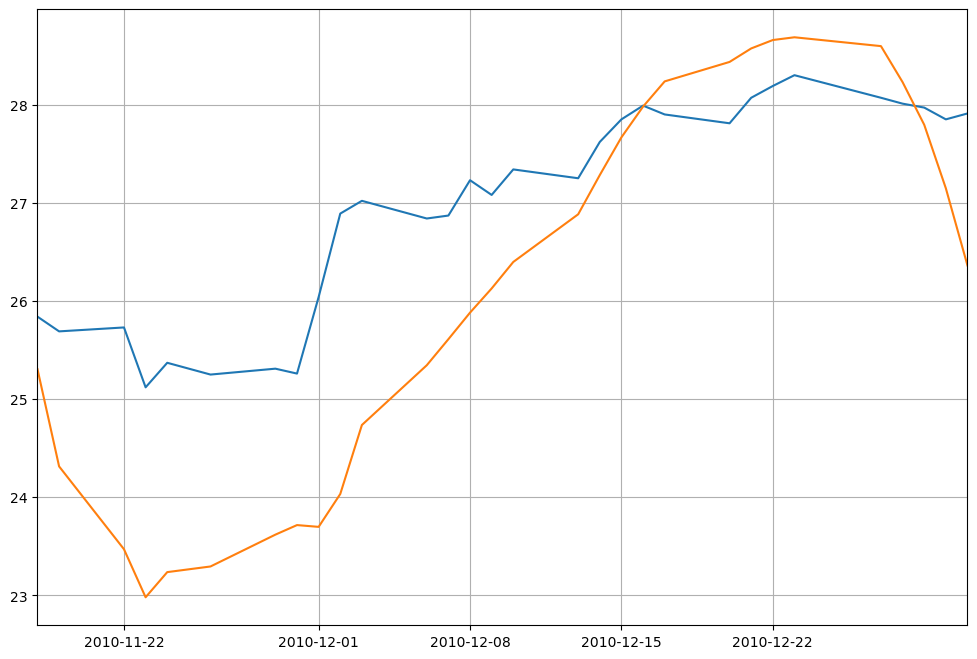

In [28]:
plt.figure(figsize=(12,8))
plt.autoscale(axis='x',tight=True)
plt.plot(df['Close'].iloc[-future:])
plt.plot(dates,future_predictions)
plt.grid(True)
plt.show()